In [65]:
%%time
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import re
from pandas import DataFrame
from bs4 import BeautifulSoup
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import numpy as np
import scipy as sp
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#nltk.download('stopwords')
stop = stopwords.words('english')

def preprocessor(text):
    # remove HTML tags
    text = BeautifulSoup(text, 'html.parser').get_text()
    
    # regex for matching emoticons, keep emoticons, ex: :), :-P, :-D
    r = '(?::|;|=|X)(?:-)?(?:\)|\(|D|P)'
    emoticons = re.findall(r, text)
    text = re.sub(r, '', text)
    
    # convert to lowercase and append all emoticons behind (with space in between)
    # replace('-','') removes nose of emoticons
    text = re.sub('[\W]+', ' ', text.lower()) + ' ' + ' '.join(emoticons).replace('-','')
    return text


def tokenizer_stem(text):
    porter = PorterStemmer()
    return [porter.stem(word) for word in re.split('\s+', text.strip())]

def tokenizer_by_tense(sentence):
    tokens = nltk.word_tokenize(sentence)
    tagged = nltk.pos_tag(tokens)
    important_words = []
    for t in tagged:
        tag_name = t[1][0:2]
        word = t[0].lower()
        if tag_name=='NN' or tag_name=='JJ' or tag_name=='VB' or tag_name=='RB':
            porter = PorterStemmer()
            important_words.append(word)
        
    return [porter.stem(w) for w in important_words if w not in stop and re.match('[a-zA-Z]+', w)]

def tokenizer_stem_nostop(text):
    porter = PorterStemmer()
    return [porter.stem(w) for w in re.split('\s+', text.strip()) \
            if w not in stop and re.match('[a-zA-Z]+', w)]

df_train = pd.read_csv('datasets/train.csv')
df_test = pd.read_csv('datasets/test.csv')
sample_submission = pd.read_csv('datasets/sample_submission.csv')
#print(df_train.head(5))
#print(df_test.head(5))
page0 = df_train.loc[0,'Page content']
#print(page0)
df_small = df_train.sample(n=10000,random_state=0)
#print(df_small.iloc[0]['Page content'])
DF_train = pkl.load(open('outputs/df_train.pkl', 'rb'))
DF_test = pkl.load(open('outputs/df_test.pkl', 'rb'))

CPU times: user 4.24 s, sys: 539 ms, total: 4.78 s
Wall time: 4.86 s


In [2]:
# Parse datetime from html
from dateutil import parser

# Extract features from raw HTML
# Usage: 
# page0 = df.loc[0,'Page content']
# extract_feature(page0)
def extract_feature(html):
    
    bs = BeautifulSoup(html, 'html.parser')
    
    # link
    link_count = len(bs.findAll('a', href=True)) 
    
    # image
    img_count = len(bs.findAll('img'))
    
    # animation, chart or video
    iframe_count = len(bs.findAll('iframe'))
    
    # quote
    quote_count = len(bs.findAll('blockquote'))
    
    # tags
    tags = [] 
    for tag in bs.select('footer a'):
        tags.append(tag.string)
        
    # category
    category = ""
    for cat in bs.findAll('article'):
        try:
            category = cat['data-channel']
            break
        except:
            category = ""
            continue
            
    # author (seem not notable) -> discard(?)
    '''
    author_raw = bs.find("div", { "class" : "article-info" })
    try:
        author = author_raw.find('a')['href']
    except:
        pass
    
    try:
        author = author_raw.find('span',{'class':'author_name'}).string
    except:
        pass
    '''
    
    # title info. (h1) (must be helpful)
    title = bs.find("h1", { "class" : "title" }).string
    title_words_count = len(re.split(r'\s+', title))
    title_digits_count = len([int(s) for s in title.split() if s.isdigit()])
    title_question_mark = ('?' in title) # boolean
    title_exclamation_mark = ('!' in title) # boolean
    
    # sub-title (h2) (must be helpful)
    # count how many sub-title in the article
    try:
        h2 = bs.find('h2')
        sub_title_count = len(bs.find('h2'))
    except:
        sub_title_count = 0
    
    # get word set
    pre_text = preprocessor(html)
    tokens = tokenizer_by_tense(pre_text)
    total_word_count = len(tokens)
    
    # date
    try:
        datetime = bs.time['datetime']
        l = re.split(r'\s+', datetime)
        weekday = re.sub(',','',l[0])
        day = l[1]
        month = l[2]
        year = l[3]
        time = l[4]
        t = int(time.split(':')[0]) # 
        if t in [0,3]: 
            time_interval = 1 # 0~3
        elif t in [4,7]: 
            time_interval = 2 # 4~7
        elif t in [8,11]: 
            time_interval = 3 # 8~11
        elif t in [12,15]:
            time_interval = 4 # 12~15 
        elif t in [16,19]:
            time_interval = 5 # 16~19
        else: 
            time_interval = 6 # 20~23
    except:
        weekday = 'Mon'
        day = 0
        month = ''
        year = '2013'
        time = 0
        time_interval = 1
    
    # return 
    tmp = []
    tmp.append(link_count)
    tmp.append(img_count)
    tmp.append(iframe_count)
    tmp.append(quote_count)
    tmp.append(tags)
    tmp.append(category)
    #tmp.append(author)
    tmp.append(total_word_count)
    
    #tmp.append(parsed_date)
    tmp.append(weekday)
    tmp.append(day)
    tmp.append(month)
    tmp.append(year)
    tmp.append(time)
    tmp.append(time_interval)
    
    tmp.append(title_words_count)
    tmp.append(title_digits_count)
    tmp.append(sub_title_count)
    tmp.append(title_question_mark)
    
    return tmp

In [59]:
%%time 
# about 25min for df_train
# about 11min for df_test
dd = df_train
dsize = dd.shape[0] #df_train.shape[0] #df_small.shape[0] 
link_count=[]
img_count=[]
iframe_count=[]
quote_count=[]
tags=[]
categories=[]
authors=[]
total_word_count=[]
#parsed_date=[]
weekday=[]
day=[]
month=[]
year=[]
time=[]
time_interval=[]
title_words_count=[]
title_digits_count=[]
title_question_mark=[]
sub_title_count=[]

for i in range(dsize):
    features = extract_feature(dd.iloc[i]['Page content'])
    link_count.append(features[0])
    img_count.append(features[1])
    iframe_count.append(features[2])
    quote_count.append(features[3])
    tags.append(features[4])
    categories.append(features[5])
    #authors.append(features[6])
    total_word_count.append(features[6])
    #parsed_date.append(features[8])
    weekday.append(features[7])
    day.append(features[8])
    month.append(features[9])
    year.append(features[10])
    time.append(features[11])
    time_interval.append(features[12])
    title_words_count.append(features[13])
    title_digits_count.append(features[14])
    sub_title_count.append(features[15])
    title_question_mark.append(features[16])
#########################################################
d = {
     '#link':link_count,
     '#img':img_count,
     '#iframe':iframe_count,
     '#quote':quote_count,
     #'tags':tags,
     'categories':categories,
     #'authors':authors,
     '#total word':total_word_count,
     #'date':parsed_date,
     'weekday':weekday,
     #'day':day,
     #'month':month,
     'year':year,
     #'time':time,
     'time interval(4hr)':time_interval,
     '#title word':title_words_count,
     '#title digits':title_digits_count,
     '#sub-title':sub_title_count,
     'If title contains "?"':title_question_mark,
     'popularity':dd['Popularity'] #
    }

CPU times: user 27min 11s, sys: 29.3 s, total: 27min 40s
Wall time: 27min 58s


In [61]:
df = DataFrame(data=d)
'''
X = df.drop('popularity', 1)
y = df['popularity']

# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

print('#Training data points: %d' % X_train.shape[0])
print('#Testing data points: %d' % X_test.shape[0])
print('Class labels:', np.unique(y))
'''
display(df.head(5))
print(df.shape)

,#iframe,#img,#link,#quote,#sub-title,#title digits,#title word,#total word,"If title contains ""?""",categories,popularity,time interval(4hr),weekday,year
0,0,1,22,0,0,0,8,351,False,world,-1,4,Wed,2013
1,0,2,18,0,0,0,12,205,False,tech,1,6,Thu,2013
2,25,2,11,0,1,1,12,655,False,entertainment,1,5,Wed,2014
3,21,1,13,0,1,0,5,179,False,watercooler,-1,6,Fri,2013
4,1,52,16,1,1,0,10,994,False,entertainment,-1,1,Thu,2014


(27643, 14)


In [159]:
# Best score of 0.53196 with RandomForest
df = DF_train
df = df.drop('If title contains "?"', 1)
df = df.drop('#sub-title', 1)
df = df.drop('year', 1)
df = df.drop('#title digits', 1)
df = df.drop('#quote', 1)

In [160]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

# encode categorical features
catego_features = ['categories','time interval(4hr)','weekday'] #['If title contains "?"','categories','time interval(4hr)','weekday','year']

catego_le = LabelEncoder()

# transform categorical values into numerical values
# be careful that '?' will also be encoded
# we have to replace it to NaN in numerical
num_values = []
for i in catego_features:
    df[i] = catego_le.fit_transform(df[i].values)
    classes_list = catego_le.classes_.tolist()
    
    # store the total number of values
    num_values.append(len(classes_list))
    
    # replace '?' with 'NaN'
    if '?' in classes_list:
        idx = classes_list.index('?')
        df[i] = df[i].replace(idx, np.nan)

display(df.head(5))
print(df.shape)

,#iframe,#img,#link,#title word,#total word,categories,popularity,time interval(4hr),weekday
0,0,1,22,8,351,32,-1,3,6
1,0,2,18,12,205,28,1,5,4
2,25,2,11,12,655,7,1,4,6
3,21,1,13,5,179,31,-1,5,0
4,1,52,16,10,994,7,-1,0,4


(27643, 9)


In [163]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score

# randomly sample 1000 examples
#df_small = df_train.sample(n=1000, random_state=0)

names = ['LogisticRegression', 
         'DecisionTreeClassifier',
         'RandomForestClassifier',
         'Perception',
         'SGDClassifier',
         'KNN',
         'SVC',
         'KMeans'
        ]

# LogisticRegression
pipe1 = Pipeline([('clf', LogisticRegression())])
# DecisionTreeClassifier
pipe2 = Pipeline([('clf', DecisionTreeClassifier())])
# RandomForest
pipe3 = Pipeline([('clf', RandomForestClassifier())])
# Perceptron
pipe4 = Pipeline([('clf', Perceptron())])
# SGDClassifier
pipe5 = Pipeline([('clf', SGDClassifier())])
# KNN
pipe6 = Pipeline([('clf', KNeighborsClassifier())])
# KMeans
pipe7 = Pipeline([('clf', KMeans())])

# CV
print('[auc (10-fold cv)]')
for name, clf in zip(names, [pipe1, pipe2, pipe3, pipe4, pipe5, pipe6]):
    scores = cross_val_score(estimator=clf, X=df.drop('popularity', 1), y=df['popularity'], \
                         cv=10, scoring='roc_auc')
    print('%s: %.3f (+/-%.3f)' % (name, scores.mean(), scores.std()))

[auc (10-fold cv)]
LogisticRegression: 0.536 (+/-0.012)
DecisionTreeClassifier: 0.511 (+/-0.012)
RandomForestClassifier: 0.527 (+/-0.011)
Perception: 0.501 (+/-0.019)
SGDClassifier: 0.511 (+/-0.015)
KNN: 0.508 (+/-0.008)


In [171]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = df.drop('popularity', 1)
y = df['popularity']
# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(X_train_std, y_train)

y_pred = lr.predict(X_test_std)
print('Accuracy (logistic): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (logistic): 0.54


In [157]:
%%time
from sklearn.preprocessing import StandardScaler

X = df
sc = StandardScaler()
sc.fit(X)
X_std = sc.transform(X)

y_pred = lr.predict(X_std)

CPU times: user 2.57 ms, sys: 1.47 ms, total: 4.04 ms
Wall time: 2.67 ms


In [147]:
from sklearn.ensemble import RandomForestClassifier

# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=300, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy (forest): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (forest): 0.53


In [150]:
%%time
X = df
y_pred = forest.predict(X)

CPU times: user 971 ms, sys: 62.2 ms, total: 1.03 s
Wall time: 541 ms


In [158]:
df_out = sample_submission
#df_out.loc[:,'Popularity'] = y_pred
df_out['Popularity'] = y_pred
df_out.head(5)
#print(df_out.shape)
df_out.to_csv('outputs/submission.csv')

In [104]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# criterion : impurity function
# n_estimators :  number of decision trees
# random_state : seed used by the random number generator
# n_jobs : number of cores for parallelism
forest = RandomForestClassifier(criterion='entropy',
                                n_estimators=200, 
                                random_state=1,
                                n_jobs=2)

X = df.drop('popularity', 1)
y = df['popularity']
# split X into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
print('Accuracy (forest): %.2f' % accuracy_score(y_test, y_pred))

Accuracy (forest): 0.52


 1) #total word                    0.237584
 2) #link                          0.166372
 3) #title word                    0.113196
 4) #img                           0.106251
 5) categories                     0.095686
 6) weekday                        0.059261
 7) time interval(4hr)             0.058228
 8) #iframe                        0.053368
 9) #quote                         0.038822
10) year                           0.023923
11) #title digits                  0.019101
12) #sub-title                     0.017407
13) If title contains "?"          0.010802


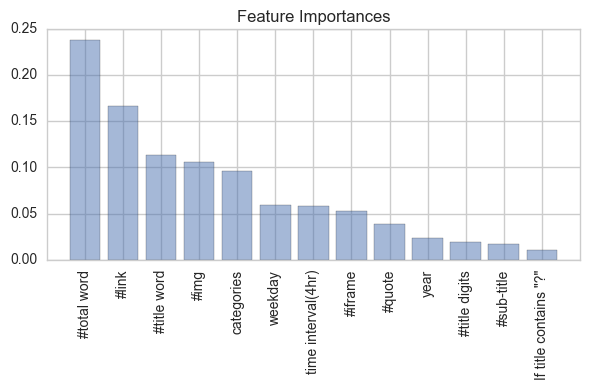

In [105]:
# inline plotting instead of popping out
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

importances = forest.feature_importances_
# get sort indices in descending order
indices = np.argsort(importances)[::-1]
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            X.columns.values[indices[f]], 
                            importances[indices[f]]))

plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center',
        alpha=0.5)

plt.xticks(range(X_train.shape[1]), 
           X.columns.values[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

In [16]:
%%time
def tfidf_generator(df):
    tfidf = TfidfVectorizer(ngram_range=(1,1),
                        preprocessor=preprocessor,
                        tokenizer=tokenizer_stem_nostop)
    doc = []
    for i in range(df.shape[0]):
        try:
            doc.append(df_train[df_train.Id == i].loc[i,'Page content'])
        except:
            pass
    
    tfidf.fit(doc)
    doc_tfidf = tfidf.transform(doc).toarray()
    return pd.DataFrame(doc_tfidf)

#df_small_tfidf = tfidf_generator(df_small)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [98]:
%%time
# import optimized pickle written in C for serializing and 
# de-serializing a Python object
import _pickle as pkl
import sys
sys.setrecursionlimit(10000)

df = DataFrame(data=d)

# dump to disk
pkl.dump(df, open('outputs/df.pkl', 'wb'))

# load from disk
df = pkl.load(open('outputs/df.pkl', 'rb'))

CPU times: user 121 ms, sys: 345 ms, total: 466 ms
Wall time: 497 ms
